In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

from utils import display 

In [2]:
# Paramters
IMAGE_SIZE = 32
CHANNELS = 1 #Grayscale
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [10]:
# Load data
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 4s 1us/step


In [11]:
# Preprocess the data
def preprocess(imgs):
    imgs= imgs.astype("float32")/255.0
    imgs= np.pad(imgs, ((0,0), (2,2), (2,2)), constant_values=0.0)
    imgs= np.expand_dims(imgs, -1)
    return imgs

X_train= preprocess(X_train)
X_test= preprocess(X_test)

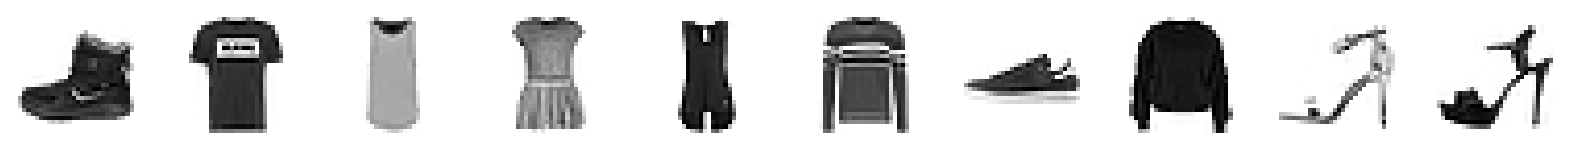

In [12]:
display(X_train)

In [13]:
# Encoder
encoder_input= layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name= "encoder_input"
)
x= layers.Conv2D(32, (3,3), strides= 2, activation= "relu", padding= "same")( encoder_input)
x= layers.Conv2D(64, (3,3), strides= 2, activation= "relu", padding="same") (x)
x= layers.Conv2D(128, (3,3), strides= 2, activation= "relu", padding="same")(x)
before_flattening= K.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output= layers.Dense(EMBEDDING_DIM, name= 'encoder_ouput')(x)
encoder= models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_ouput (Dense)       (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

In [15]:
# Decoder
decoder_input= layers.Input(shape=(EMBEDDING_DIM,), name= "decoder_input")
x= layers.Dense(np.prod(before_flattening))(decoder_input)
x= layers.Reshape(before_flattening)(x)
x= layers.Conv2DTranspose(128, (3,3), strides= 2, activation= "relu", padding="same")(x)
x= layers.Conv2DTranspose(64, (3,3), strides= 2, activation="relu", padding= "same")(x)
x= layers.Conv2DTranspose(32, (3,3), strides= 2, activation="relu", padding= "same")(x)
decoder_output=layers.Conv2D(
    CHANNELS,
    (3,3),
    strides=1,
    activation= "sigmoid",
    padding= "same",
    name= "decoder_output",
)(x)
decoder= models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

In [16]:
# Autoencoder
autoencoder= models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_ouput (Dense)       (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

In [17]:
# Train choo choo

# compile 
autoencoder.compile(optimizer="adam", loss= "binary_crossentropy")

In [18]:
model_checkpoints_callback= callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback= callbacks.TensorBoard(log_dir="./logs")

In [20]:
autoencoder.fit(
    X_train,
    X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[model_checkpoints_callback, tensorboard_callback],
)

Epoch 1/3
600/600 [==============================] - ETA: 0s - loss: 0.2970

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


600/600 [==============================] - 87s 140ms/step - loss: 0.2970 - val_loss: 0.2621
Epoch 2/3
600/600 [==============================] - ETA: 0s - loss: 0.2582

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


600/600 [==============================] - 74s 123ms/step - loss: 0.2582 - val_loss: 0.2570
Epoch 3/3
600/600 [==============================] - ETA: 0s - loss: 0.2545

INFO:tensorflow:Assets written to: .\checkpoint\assets


INFO:tensorflow:Assets written to: .\checkpoint\assets


600/600 [==============================] - 82s 137ms/step - loss: 0.2545 - val_loss: 0.2549


In [21]:
autoencoder.save("./models/autoencoder")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

INFO:tensorflow:Assets written to: ./models/autoencoder\assets


INFO:tensorflow:Assets written to: ./models/autoencoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/encoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


INFO:tensorflow:Assets written to: ./models/decoder\assets


In [22]:
n_to_predict = 5000
example_images = X_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 4s 22ms/step
example real cloths


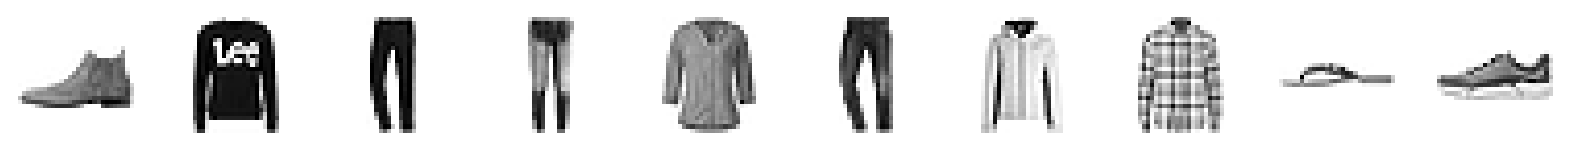

reconstructions


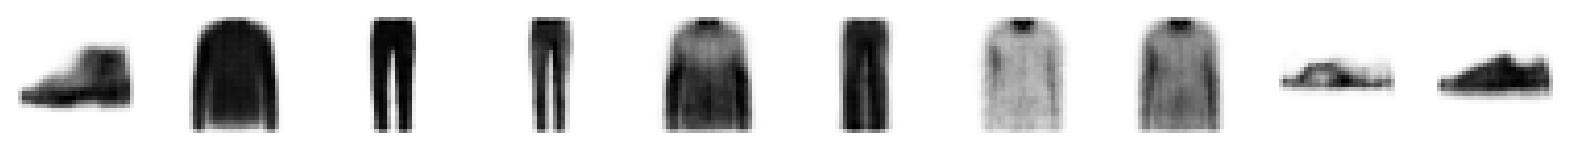

In [23]:
preds= autoencoder.predict(example_images)
print("example real cloths")
display(example_images)
print("reconstructions")
display(preds)

In [24]:
embeds= encoder.predict(example_images)

157/157 [==============================] - 1s 6ms/step


In [25]:
print(embeds)

[[ -5.14431      2.8955119 ]
 [ -0.18711846  -1.1120412 ]
 [ -0.49559733 -15.52127   ]
 ...
 [  0.13778304   3.047943  ]
 [ -1.2766877   -4.9762864 ]
 [ -7.9181046    1.4613234 ]]


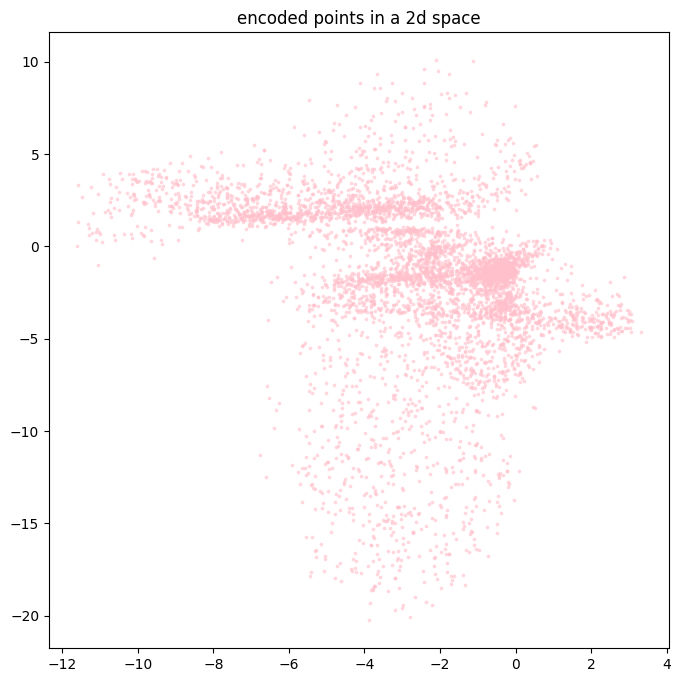

In [27]:
# encoded points in a 2d space
fs=8
plt.figure(figsize=(fs, fs))
plt.title("encoded points in a 2d space")
plt.scatter(embeds[:,0], embeds[:,1], c="pink", alpha= 0.5, s=3)
plt.show()

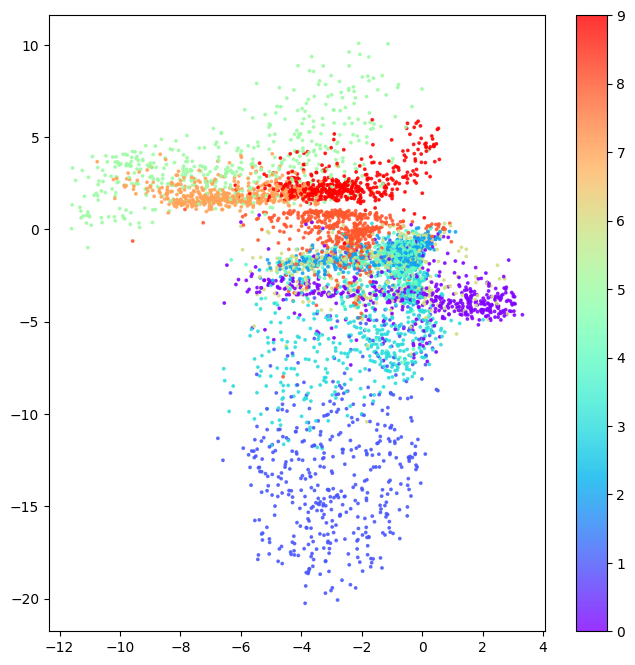

In [28]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeds[:, 0],
    embeds[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [29]:
mins, maxs= np.min(embeds, axis=0), np.max(embeds, axis=0)
grid_w, grid_h = (6,3)
sample= np.random.uniform(mins, maxs, size= (grid_w+grid_h, EMBEDDING_DIM))

In [30]:
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 159ms/step


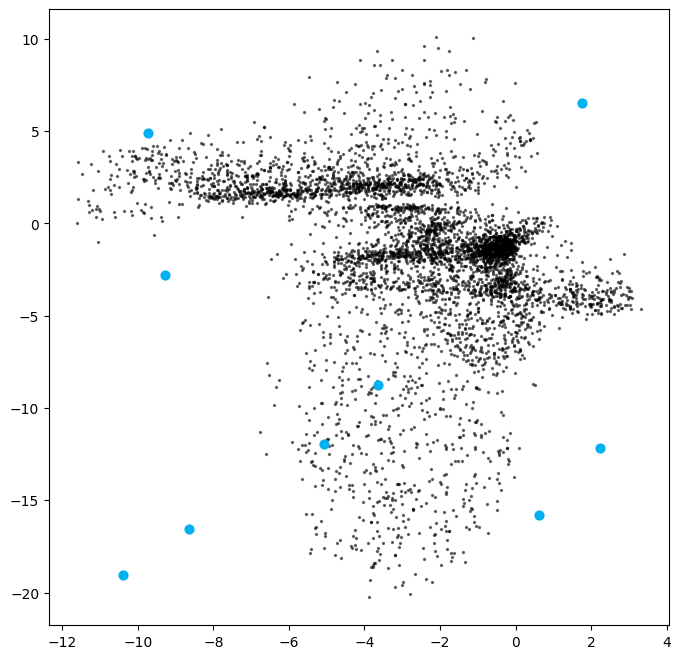

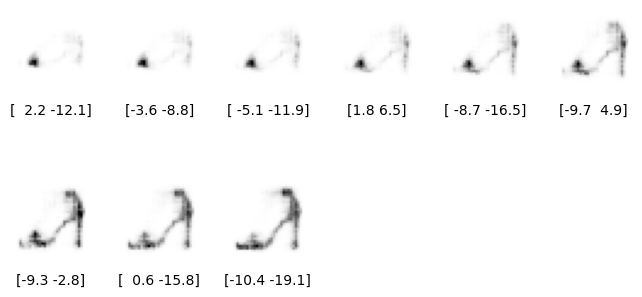

In [33]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeds[:, 0], embeds[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_h * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

n = sample.shape[0]  # number of samples
for i in range(n):
    ax = fig.add_subplot(grid_h, grid_w, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i], cmap="Greys")

8/8 [==============================] - 0s 15ms/step


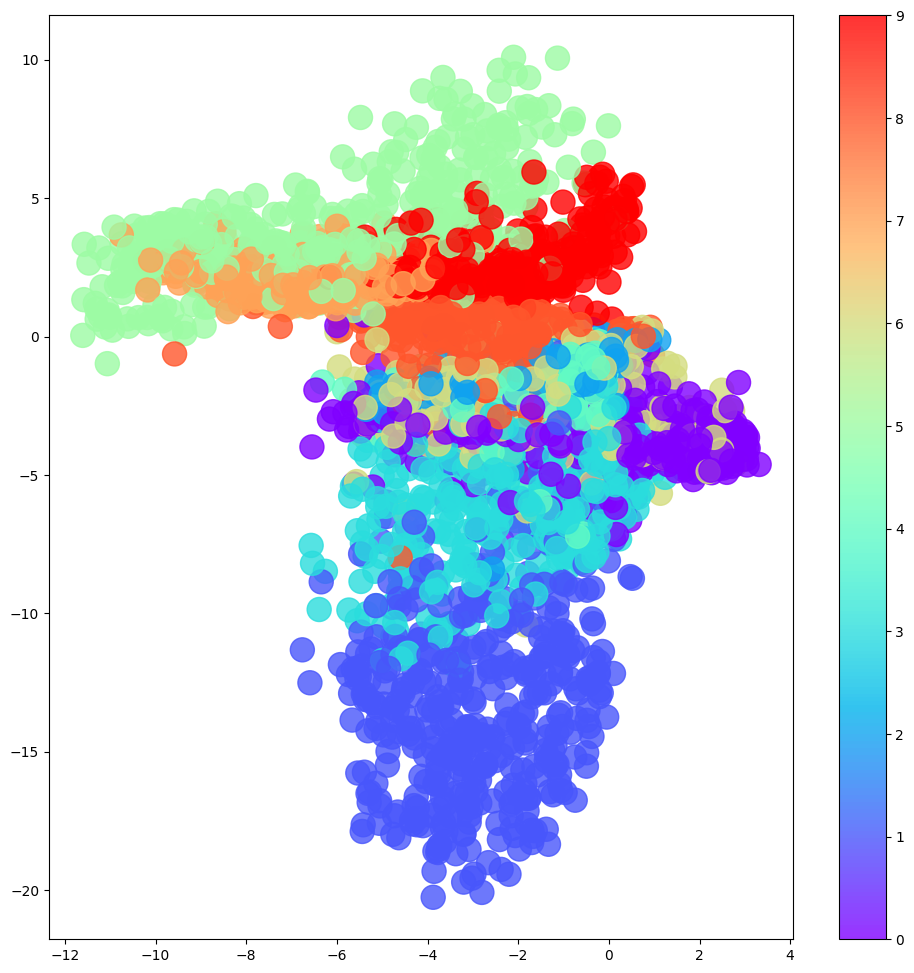

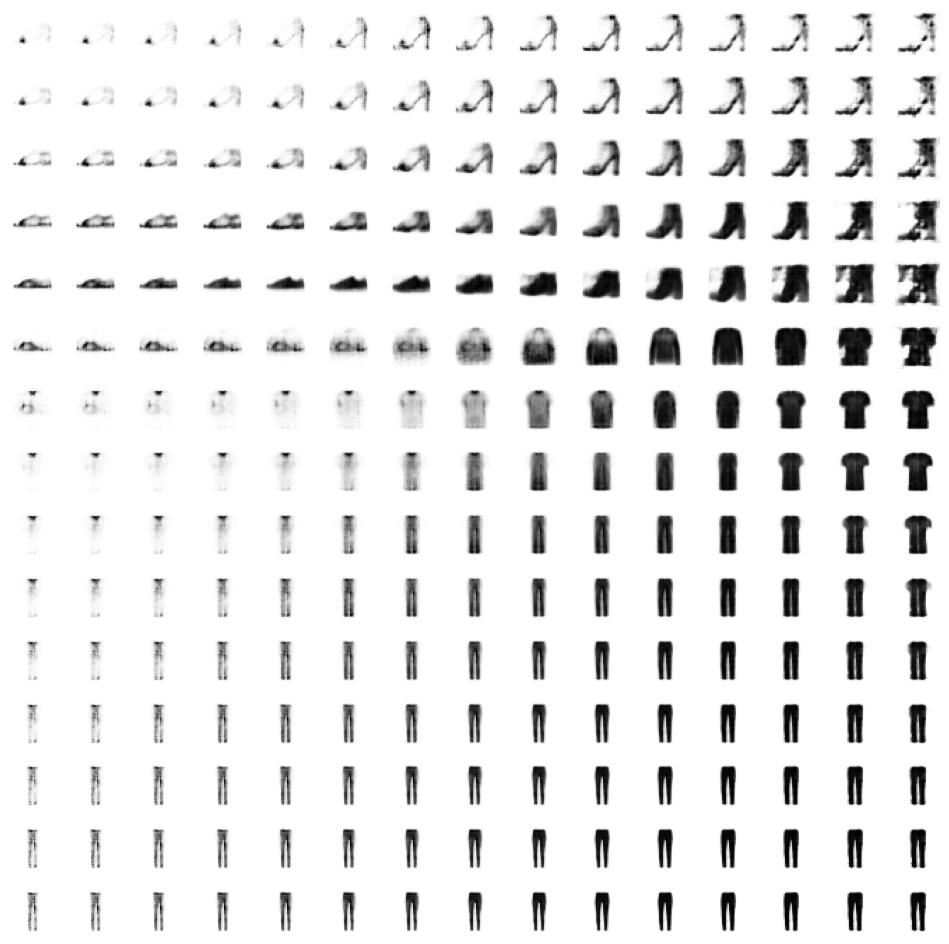

In [32]:
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeds[:, 0],
    embeds[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeds[:, 0]), max(embeds[:, 0]), grid_size)
y = np.linspace(max(embeds[:, 1]), min(embeds[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")